# Introduction

This notebook runs the finite difference groundwater model MODFLOW 6 (USGS) for 3 example problems: a simple soil tube, sheet pile wall and a levee cross section. Users can change the boundary conditions and parameters used in the model to better understand the physical processes associated with groundwater flow, especially as it relates to the design and assessment of earth embankments. The models are set up to solve the groudnwater flow equation (i.e., Richard's equation, Darcy's Law) in 2D for steady-state saturated conditions. Unsaturated and transient cases aren't considered in this notebook.

If you are reading this notebook through Binder you can run it and change anything you want via the web browser. To run this notebook on your own computer you will need two things:
1. a local Python installation is available, and 
2. the MODFLOW 6 executable file is in same folder as this notebook (`mf6.exe`)

*This notebook is a work in progress and we hope to use it more in future years, so please post any questions or comments on the Teams channel for the course!*

*Thank you to Marjolijn Mascini for setting up this notebook and Examples 1 & 2, and to Lisa van der Linde for creating the levee model in Example 3!*

*This notebook is provided for students in the course CIE5314-19 Flood Defences at TU Delft in May, 2022. Please contact Robert Lanzafame (R.C.Lanzafame@tudelft.nl) if you would like to share...not because the material is sensitive, but because there may be a new version.*

In [2]:
import sys
import os
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
plt.rcParams.update({'font.size':18}) # Use for all plots

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join("..", ".."))
    sys.path.append(fpth)
    import flopy

# Example 1: Darcy

In [3]:
workspace = os.path.join("Data", "Example1")
if not os.path.isdir(workspace):
    os.makedirs(workspace, exist_ok=True)

In [4]:
name = "Example1"
length_units = "Meter"
time_units = "DAYS"

nper = 1
Nlay = 10
nrows = 5
ncol = 50
delr = 1
delc = 1

vk = 0.5/1000 #m/day
top = 10
hk = 1.0/1000 #m/day
H = 10
L = 50

h_k = hk * np.ones((Nlay,nrows,ncol))
hk33 = vk * np.ones((Nlay, nrows, ncol))

tdis_ds = [(1.0, 1, 1.0)]



In [5]:
sim = flopy.mf6.MFSimulation(
    sim_name=name, exe_name="mf6",
    version="mf6", sim_ws=workspace
)
# Create the Flopy temporal discretization object
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(
    sim, pname="tdis", time_units="DAYS", nper=nper, perioddata=tdis_ds,
)


# Create the Flopy groundwater flow (gwf) model object
model_nam_file = "{}.nam".format(name)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, model_nam_file=model_nam_file, newtonoptions="newton")

# Create the discretization package
bot = np.linspace(-H / Nlay+top, -H+top, Nlay)
delrow = delr
delcol = delc
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
    gwf,
    pname="dis",
    nlay=Nlay,
    nrow=nrows,
    ncol=ncol,
    delr=delrow,
    delc=delcol,
    top=top,
    botm=bot,
    length_units = "METERS"
)


flopy.mf6.ModflowGwfsto(
    gwf,
    iconvert=1,
    steady_state={0:True}
)
# Create the node property flow package
npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
    gwf, pname="npf", icelltype=1, k=h_k, k33=hk33, save_flows=True, save_saturation=True, save_specific_discharge=True,
)


# Create the Flopy iterative model solver (ims) Package object
ims = flopy.mf6.modflow.mfims.ModflowIms(sim, pname="ims", linear_acceleration="BICGSTAB")


In [6]:
# Create the initial conditions package
h1 = 15 
start = h1 * np.ones((Nlay, nrows, ncol))
start[0,:,0] = 2.5
start[0,:,-1] = 1.5
ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname="ic", strt=start)

In [7]:
chd_rec = []
for i in range(Nlay):
    for j in range(nrows):
        chd_rec.append(((i, j, 0), 20))
        chd_rec.append(((i, j, 49), 15))

chd = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(
    gwf,
    pname="chd",
    maxbound=len(chd_rec),
    stress_period_data=chd_rec,
    save_flows=True,
)


In [8]:
# Create the output control package
headfile = "{}.hds".format(name)
head_filerecord = [headfile]
budgetfile = "{}.cbb".format(name)
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]
oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(
    gwf,
    pname="oc",
    saverecord=saverecord,
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
    printrecord=printrecord,
)

In [9]:
sim.write_simulation(silent=True)

In [10]:
success, buff = sim.run_simulation()
print("\nSuccess is: ", success)

FloPy is using the following executable to run the model: .\mf6.EXE
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.2 07/30/2021

   MODFLOW 6 compiled Jul 30 2021 14:34:58 with IFORT compiler (ver. 19.10.2)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources Software Use

In [11]:
#Get heads in model
fname = os.path.join(workspace, headfile)
hds = flopy.utils.binaryfile.HeadFile(fname)

Heads_case1 = [(hds.get_data(kstpkper=(0, 0)))]

h0 = hds.get_data(kstpkper=(0, 0))


In [12]:
# Get Watertable
WT_case1_row3 =[]

for i in range(len(Heads_case1)):
    WT_case1 = flopy.utils.postprocessing.get_water_table(Heads_case1[i], nodata=False)
    WT_case1_row3.append(WT_case1[0])
   


In [13]:
def plot_water_table(wt, row=1):
    x = np.linspace(0+0.5*delc, L-0.5*delc, ncol)
    for i in range(len(wt)):
        plt.plot(x, wt[i], lw=4)
        

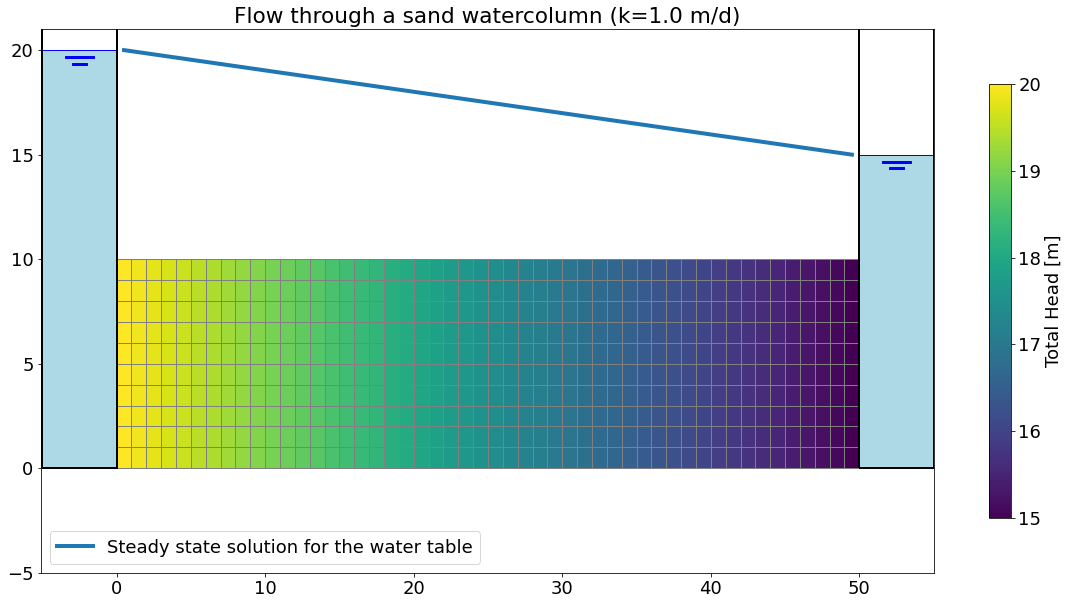

In [14]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
cros_mp=flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={'row': 1})  
pa = cros_mp.plot_array(Heads_case1[0])

linecollection = cros_mp.plot_grid(lw=1, color="0.5")

cb = plt.colorbar(pa, shrink=0.8, ax=ax, label="Total Head [m]")
plot_water_table(wt=WT_case1_row3)
plt.legend(['Steady state solution for the water table'])
ax.set_ylim([-5, 21])
ax.set_xlim([-5.1, 55])

rect = Rectangle((-5, 0), 5, 20, linewidth=1, edgecolor='blue', facecolor='lightblue')
rect_3 = Rectangle((-5, 0), 5, 25, linewidth=2, edgecolor='black', facecolor='none')
rect_2 = Rectangle((50, 0), 5, 15, linewidth=1, edgecolor='blue', facecolor='lightblue')
rect_4 = Rectangle((50, 0), 5, 25, linewidth=2, edgecolor='black', facecolor='none')
wt_1 = Rectangle((-3.5, 19.6), 2, 0.1, linewidth=1, edgecolor='blue', facecolor='blue')
wt_2 = Rectangle((-3, 19.3), 1, 0.1, linewidth=1, edgecolor='blue', facecolor='blue')
wt_3 = Rectangle((51.5, 14.6), 2, 0.1, linewidth=1, edgecolor='blue', facecolor='blue')
wt_4 = Rectangle((52, 14.3), 1, 0.1, linewidth=1, edgecolor='blue', facecolor='blue')
ax.add_patch(rect)
ax.add_patch(rect_2)
ax.add_patch(rect_3)
ax.add_patch(rect_4)
ax.add_patch(wt_1)
ax.add_patch(wt_2)
ax.add_patch(wt_3)
ax.add_patch(wt_4)
ax.set_title("Flow through a sand watercolumn (k=1.0 m/d)");

# Example 2: flow around a sheet pile wall

In [15]:
workspace = os.path.join("data", "Example2")
if not os.path.isdir(workspace):
    os.makedirs(workspace, exist_ok=True)

In [16]:
name = "Soil_column"

nper = 1
Nlay = 51
nrows = 11
ncol = 200
delr = 1
delc = 1

vk = 0.5 #m/day
top = 0
hk = 1.0 #m/day
H = 10
L = 200

h_k = hk * np.ones((Nlay,nrows,ncol))
hk33 = vk * np.ones((Nlay, nrows, ncol))

tdis_ds = [(1.0, 1, 1.0)]


In [17]:
sim = flopy.mf6.MFSimulation(
    sim_name=name, exe_name="mf6", 
    version="mf6", sim_ws=workspace
)
# Create the Flopy temporal discretization object
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(
    sim, pname="tdis", time_units="DAYS", nper=nper, perioddata=tdis_ds,
)


# Create the Flopy groundwater flow (gwf) model object
model_nam_file = "{}.nam".format(name)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, model_nam_file=model_nam_file, newtonoptions="NEWTON UNDER_RELAXATION",)

# Create the discretization package
bot = np.linspace(-H / Nlay+top, -H+top, Nlay)
delrow = delr
delcol = delc
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
    gwf,
    pname="dis",
    nlay=Nlay,
    nrow=nrows,
    ncol=ncol,
    delr=delrow,
    delc=delcol,
    top=top,
    botm=bot,
    length_units = "METERS"
)


# Create the node property flow package
npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
    gwf, pname="npf", icelltype=1, k=h_k, k33=hk33, save_flows=True, save_saturation=True, save_specific_discharge=True,
)


# Create the Flopy iterative model solver (ims) Package object
ims = flopy.mf6.modflow.mfims.ModflowIms(sim, pname="ims", complexity="complex", linear_acceleration="BICGSTAB")


In [18]:
# Create the initial conditions package
h1 = 0 
start = h1 * np.ones((Nlay, nrows, ncol))
start[0,:,0] = 10
start[0,:,-1] = 0
ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname="ic", strt=start)

In [19]:
colls_till_wall = 100
chd_rec = []
for j in range(nrows):
    chd_rec.append(((0, j, 199), 0))
    for k in range(colls_till_wall):
        chd_rec.append(((0, j, k), 10))


chd = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(
    gwf,
    pname="chd",
    maxbound=len(chd_rec),
    stress_period_data=chd_rec,
    save_flows=True,
)

iper = 0
ra = chd.stress_period_data.get_data(key=iper)

In [20]:
# Sheet pile wall 
hfb_data = []

for i in range(nrows):
    for j in range(25):
        hfb_data.append([j, i, colls_till_wall, j, i, colls_till_wall+1, 10**-8])

hfb = flopy.mf6.ModflowGwfhfb(gwf, stress_period_data=hfb_data)

In [21]:
# Create the output control package
headfile = "{}.hds".format(name)
head_filerecord = [headfile]
budgetfile = "{}.cbb".format(name)
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]
oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(
    gwf,
    pname="oc",
    saverecord=saverecord,
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
    printrecord=printrecord,
)

In [22]:
sim.write_simulation(silent=True)

In [23]:
success, buff = sim.run_simulation()
print("\nSuccess is: ", success)

FloPy is using the following executable to run the model: .\mf6.EXE
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.2 07/30/2021

   MODFLOW 6 compiled Jul 30 2021 14:34:58 with IFORT compiler (ver. 19.10.2)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources Software Use

In [24]:
#Get heads
fname = os.path.join(workspace, headfile)
hds = flopy.utils.binaryfile.HeadFile(fname)
#head = gwf.output.head().get_data(kstpkper=(0, 0))
Heads_case1 = [(hds.get_data(kstpkper=(0, 0)))]

h0 = hds.get_data(kstpkper=(0, 0))

In [25]:
# Get Watertables
WT_case1_row3 =[]

for i in range(len(Heads_case1)):
    WT_case1 = flopy.utils.postprocessing.get_water_table(Heads_case1[i], nodata=False)
    WT_case1_row3.append(WT_case1[0])

C:\Users\rlanzafame\Anaconda3\lib\site-packages\flopy\plot\crosssection.py:598: UserWarning: The following kwargs were not used by contour: 'intervals'
  contour_set = ax.tricontour(triang, plotarray, **kwargs)


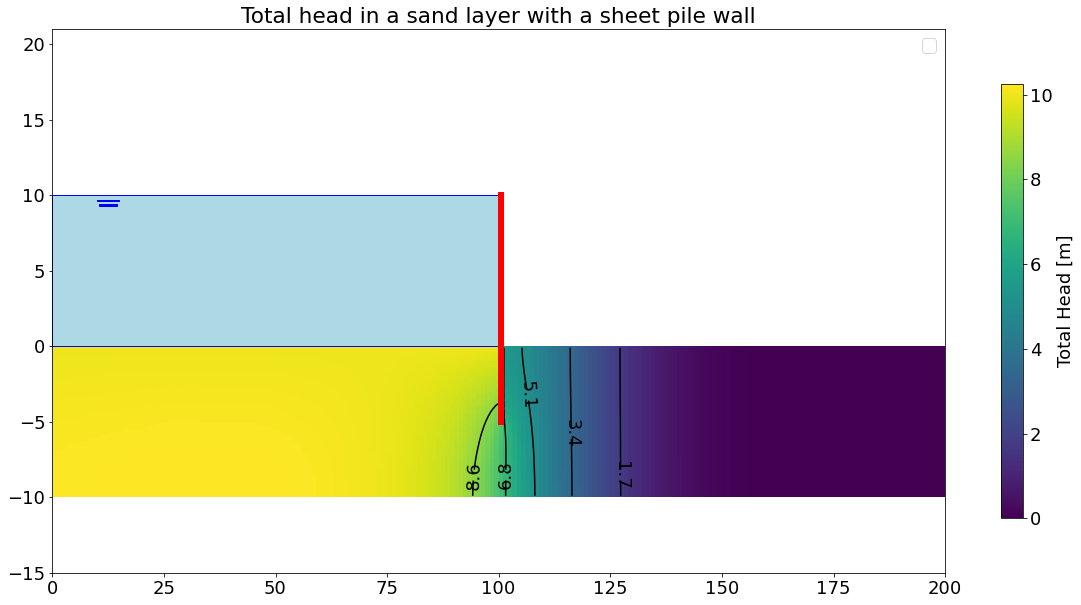

In [26]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
cros_mp=flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={'row': 1})  
pa = cros_mp.plot_array(Heads_case1)
intervals=np.arange(0, 10, 0.5)
contours = cros_mp.contour_array(
            Heads_case1,
            colors="black",
            intervals=intervals
    
        )    

ax.clabel(contours, fmt="%2.1f")

cb = plt.colorbar(pa, shrink=0.8, ax=ax, label="Total Head [m]")
#plot_water_table(wt=WT_case1_row3)
plt.legend(['Steady state solution for the water table'])
ax.set_ylim([-15, 21])
ax.set_xlim([0, 200])

rect = Rectangle((0, 0), 100, 10, linewidth=1, edgecolor='blue', facecolor='lightblue')
rect_2 = Rectangle((600, -10), 15, 10, linewidth=2, edgecolor='black', facecolor='lightblue')

wt_1 = Rectangle((10, 9.6), 5, 0.1, linewidth=1, edgecolor='blue', facecolor='blue')
wt_2 = Rectangle((10.5, 9.3), 4, 0.1, linewidth=1, edgecolor='blue', facecolor='blue')
wt_3 = Rectangle((202.5, -0.4), 5, 0.1, linewidth=1, edgecolor='blue', facecolor='blue')
wt_4 = Rectangle((203, -0.7), 4, 0.1, linewidth=1, edgecolor='blue', facecolor='blue')

ax.add_patch(rect)
ax.add_patch(rect_2)
ax.add_patch(wt_1)
ax.add_patch(wt_2)
ax.add_patch(wt_3)
ax.add_patch(wt_4)
ax.plot([100.5, 100.5], [10, -5], 
                        c="red", lw = 6)
ax.set_title("Total head in a sand layer with a sheet pile wall");

# Example 3: Flow under a dike

This example is set up with a class. First all functions are defined in which most variables of the model are defined. The class lets you choose the width of the berm and if you want to put in a sheet pile wall or not, runs the model and plots the results.
An example with a bermwidth of 0m and without a sheetpile wall is given in the cell below the cell with the definition of the class. 
- How do the heads change when you vary the width of the berm?
- What happens when you add a sheet pile wall?
 

In [27]:
class ModFlow_dike():
    
    
    def __init__(self, name = "gwf_dike_mf6"):
        """
        
        In this model modflow is used to calculate the groundwaterflow 
        underneath a dike.
        
        By varying the attributes, sheetpilewalls can be added, 
        the dike can be whidened and the boundary conditions can be changed.

        """
        
        self.name = name
        
        # grid properties
        self.Nlay = 51  # z direction
        self.Nrow = 11  # y direction
        self.Ncol = 601  # x direction
        
        # Domain dimensions
        self.Lx = 600.0  # meter
        self.Ly = 4  # meter
        self.Lz = 50.0  # meter
        
        # Soil properties
        self.k = 10.  # m/d
        self.A = 2.   # -
        self.Ss = 10**-4  #1/m
        
        # Boundary conditions
        self.H1 = 4  # m ref
        self.H2 = 1  # m ref
        self.H_ditch = 0  # m ref
        self.W_ditch = 10  # m
        self.Part_ditch = 6. # 1/x'th part of Lx
        
        # Initial conditions
        self.H_ini = 0 # m ref
        
        # Sheetpile
        self.N_wall = 10 # cells
        self.Part_wall = 6.5  # 1/x'th part of Lx
        
        # output format
        self.vmin, self.vmax = self.H_ditch, self.H1
        self.contour_intervals = np.arange(self.vmin, self.vmax, 0.3)
        
        # Dike geometry
        self.start = 20  # meter in x for the outer toe
        self.height = 8  # meter height of the dike  
        self.slope  = 0.3  # slope of the dike (inner = outer)
        self.base = 80  # meter width of the dike base   
        self.crest = 5  # meter width of the crest 
        
        # Add berm 
        self.berm_width = 0. # width of the berm
    
    
    def _calc_variables(self):
        
        # Part of L where ditch starts
        self.offset_ditch = int(self.Ncol/self.Part_ditch)  # cells
        
        # Part of L where sheetpile wall is
        self.col_wall = int(self.Ncol/ self.Part_wall)  # cells
        self.x_wall = self.col_wall*(self.Lx/(self.Ncol-1))  # meters
        
        # Depth of the wall
        self.L_wall = self.N_wall*(self.Lz/(self.Nlay-1))  # meter
        
        
    def _setup_model(self):
        """
        Create the Flopy Model Objects
        
        * Temporal discretization (`TDIS`)
        * One or more models
        * Zero or more exchanges (instructions for how models are coupled)
        * Solutions

        """
        
        # Create the FloPy simulation object
        self.sim = flopy.mf6.MFSimulation(
            sim_name=self.name, exe_name="mf6", version="mf6", 
            sim_ws="."
        )
        
        # ### Create the Flopy `TDIS` object
        tdis = flopy.mf6.ModflowTdis(
            self.sim, pname="tdis", time_units="DAYS", nper=1, 
            perioddata=[(1.0, 1, 1.0)]
        )
        
        # ### Create the Flopy `IMS` Package object
        ims = flopy.mf6.ModflowIms(
            self.sim,
            pname="ims",
            complexity="SIMPLE",
            linear_acceleration="BICGSTAB",
        )
        

        # Create the Flopy groundwater flow (gwf) model object
        model_nam_file = f"{self.name}.nam"
        self.gwf = flopy.mf6.ModflowGwf(
            self.sim,
            modelname=self.name, 
            model_nam_file=model_nam_file,
            save_flows=True,
            newtonoptions="NEWTON UNDER_RELAXATION",
        )


    def _discretize(self):
        """
        Define the discretization of the model. 

        """

        bot = np.linspace(-self.Lz/ self.Nlay, -self.Lz, self.Nlay)
        delrow = self.Ly / (self.Nrow - 1)
        delcol = self.Lx / (self.Ncol - 1)

        dis = flopy.mf6.ModflowGwfdis(
            self.gwf,
            nlay=self.Nlay,
            nrow=self.Nrow,
            ncol=self.Ncol,
            delr=delcol,
            delc=delrow,
            top=0.0,
            botm=bot,
        )
      
        
    def _set_IC(self):
        """
        Create the initial conditions (`IC`) Package

        """
        
        start = self.H_ini * np.ones((self.Nlay, self.Nrow, self.Ncol))
        ic = flopy.mf6.ModflowGwfic(self.gwf, pname="ic", strt=start)
        
        # Create the node property flow (`NPF`) Package
        matrix = np.ones((self.Nlay, self.Nrow, self.Ncol), dtype=float)
        k11 = self.k * matrix
        k33 = self.k/self.A * matrix

        npf = flopy.mf6.ModflowGwfnpf(self.gwf, icelltype=1, k=k11)#, k33=k33)
        # sto = flopy.mf6.modflow.mfgwfsto(self.gwf, ss= self.Ss)


    def _set_BC(self):
        """
        Create the constant head (`CHD`) Package
        
        """

        chd_rec = []
      
        for row in range(0, self.Nrow):
            for col in range(0, self.start):
                # Highwater top boundary
                chd_rec.append(((0, row, col), self.H1))
                
            
            for col in range(0, self.W_ditch):
                # ditch boundary
                loc_ditch = int(self.offset_ditch + self.berm_width)
                chd_rec.append(((0, row, col + loc_ditch), self.H_ditch))

        
        self.chd = flopy.mf6.ModflowGwfchd(
            self.gwf,
            stress_period_data=chd_rec,
            )
        
        iper = 0
        self.ra = self.chd.stress_period_data.get_data(key=iper)


    def _set_sheetpile(self):
        """
        Generates horizontal flow barrier (hfb)  Package 
        Barrier is located between cell 1 and cell 2

        """
        if self.N_wall == 0:
            hfb_data = []
        else:   
            hfb_data = []
            for i in range(self.N_wall):
                for j in range(self.Nrow):
                    hfb_data.append([i, j, self.col_wall,  # Cell 1
                                     i, j, self.col_wall+1, # Cell 2
                                     10**-8])

        self.hfb = flopy.mf6.ModflowGwfhfb(
            self.gwf,
            maxhfb=max(1, self.N_wall*(self.Nrow-1)),
            stress_period_data=hfb_data,
            )

    def _create_OC(self):
        """
        Create the output control (`OC`) Package

        """

        headfile = f"{self.name}.hds"
        head_filerecord = [headfile]
        budgetfile = f"{self.name}.cbb"
        budget_filerecord = [budgetfile]
        saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
        printrecord = [("HEAD", "LAST")]
        oc = flopy.mf6.ModflowGwfoc(
            self.gwf,
            saverecord=saverecord,
            head_filerecord=head_filerecord,
            budget_filerecord=budget_filerecord,
            printrecord=printrecord,
        )
        
        
    def _run_model(self, path = None): 
        """
        Run the modflow6 executable from filepath
        
        Raises
        ------
        Exception
            The model inputs are incorrect.

        Create the MODFLOW 6 Input Files and Run the Model

        """      
        
        # ### Write the datasets
        
        self.sim.write_simulation()
        
        # append filepath for the executable
        import sys
        
        if path != None:
            file = path
        else:
            try:
                cwd = os.getcwd()
                file = os.path.join(cwd, "mf6.exe")
                sys.path.append(file)
            except:
                raise Exception("MODFLOW executable not found, define path" +
                                "or place executable in current folder")
        
        
        success, buff = self.sim.run_simulation()
        if not success:
            raise Exception("MODFLOW 6 did not terminate normally.")

    
    def create_figure(self):
        """
        

        Returns
        -------
        fig : TYPE
            Figure object
        ax : TYPE
            DESCRIPTION.

        """
        fig = plt.figure(figsize=(20, 6))
        ax = fig.add_subplot(1, 1, 1)# aspect="equal")
        return fig, ax

        
    def get_output(self):
        """
        Get output from output file
        """
        
        self.h = self.gwf.output.head().get_data(kstpkper=(0, 0))


    def plot_map(self, layer = 0):
        """
        
        Parameters
        ----------
        layer : TYPE, optional
            Layer number. The default is 0 (top view).

        Returns
        -------
        Plot of the Total head

        """
        
        self.get_output()
        fig, ax = self.create_figure()
       
        modelmap = flopy.plot.PlotMapView(model=self.gwf, ax=ax)
        
        pa = modelmap.plot_array(self.h, 
                                 vmin=self.vmin, 
                                 vmax=self.vmax)
        
        quadmesh = modelmap.plot_bc("CHD")
        
        linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
        contours = modelmap.contour_array(
            self.h,
            levels=self.contour_intervals,
            colors="black",
        )    

        ax.clabel(contours, fmt="%2.1f")
        cb = plt.colorbar(pa, shrink=0.5, ax=ax)
        

    def plot_cross(self, row = 5):
        """
        
        Parameters
        ----------
        Row : TYPE, optional
            Row number. The default is 5.

        Returns
        -------
        Cross-section of the Total head

        """
        
        fig, ax_tot = self.create_figure()
        ax_tot.set_xlim(0, self.Lx)
        ax_tot.set_ylim(-self.Lz, 15)
        
        # Plot dike
        Dike_xy = np.array(self.plot_dike())
       
        
        ax_tot.plot(Dike_xy[:, 0],Dike_xy[:, 1])
        ax_tot.fill(Dike_xy[:, 0],Dike_xy[:, 1], 
                    facecolor='lightsalmon', 
                    edgecolor='orangered', linewidth=3)
         
        # Plot berm
        berm_xy = np.array(self.plot_berm())
        ax_tot.plot(berm_xy[:, 0],berm_xy[:, 1])
        
        # Plot Model
        ax = ax_tot.inset_axes([0, -self.Lz, self.Lx, self.Lz], 
                               transform=ax_tot.transData)
        self.plot_model(ax, row, ax_tot)
        
        # Plot Sheetpile
        if self.N_wall > 0:
            ax.plot([self.x_wall, self.x_wall], [0, -self.L_wall], 
                        c="red", lw = 4)
        
        
    def plot_model(self, ax, row, ax_tot):
        """
        

        Parameters
        ----------
        ax : object
            axis of the model.
        row : int
            row of the modflow model to plot.
        ax_tot : object
            axis of the overwiew image.

        Returns
        -------
        None.

        """
        
        ax.set_title(f"Total head in row {row}")
        
        modelmap = flopy.plot.PlotCrossSection(
            model=self.gwf,
            ax=ax,
            line={"row": row},
        )
        
        pa = modelmap.plot_array(self.h, vmin=self.vmin, vmax=self.vmax)
        
        quadmesh = modelmap.plot_bc("CHD")
        
        linecollection = modelmap.plot_grid(lw=0.05, color="0.5")
        
        contours = modelmap.contour_array(
            self.h,
            levels=self.contour_intervals,
            colors="black",
        )
            
        ax.clabel(contours, fmt="%2.1f")
        
        cb = plt.colorbar(pa, shrink=0.8, ax=ax_tot);
    
    
    def plot_dike(self):
        """

        Returns
        -------
        Dike_xy : list
            List of points in Polygon

        """
        
        # Calculate characteristic points of dike
        upper_left = self.start + self.height/self.slope
        upper_right = self.start + self.base - self.height/self.slope
        
        # Define list
        Dike_xy = []
        
        # Set points of dike polygon
        Dike_xy.append([self.start, 0])
        Dike_xy.append([upper_left, self.height])
        Dike_xy.append([upper_right, self.height])
        Dike_xy.append([ self.start + self.base, 0])
        Dike_xy.append([ self.start, 0])
        
        return Dike_xy


    def plot_berm(self):
        """
        
        Returns
        -------
        Berm_xy : list
            List of points in Polygon
        """
        
        # Geometry properties
        self.berm_height = 0.5*self.height
        
        # Calculate characteristic points of berm
        lower_right = self.start + self.base + self.berm_width
        upper_right = lower_right - self.berm_height/self.slope
        upper_left = self.start + self.base - self.berm_height/self.slope
        
        # Define list
        Berm_xy = []
        
        # Set points of berm polygon
        Berm_xy.append([self.start + self.base, 0])
        Berm_xy.append([lower_right, 0])
        Berm_xy.append([upper_right, self.berm_height])
        Berm_xy.append([upper_left, self.berm_height])
        Berm_xy.append([self.start + self.base, 0])
        return Berm_xy
        
    
    def run_all(self):
        """
        Run all functions
        
        """
        self._calc_variables()
        self._setup_model()
        self._discretize()
        self._set_IC()
        self._set_BC()
        self._set_sheetpile()
        self._create_OC()
        self._run_model()
        self.get_output()
        # self.plot_map(0)
        self.plot_cross(5)



writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model model_0...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 330 based on size of stress_period_data
    writing package hfb...
    writing package oc...
FloPy is using the following executable to run the model: .\mf6.EXE
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.2 07/30/2021

   MODFLOW 6 compiled Jul 30 2021 14:34:58 with IFORT compiler (ver. 19.10.2)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and re

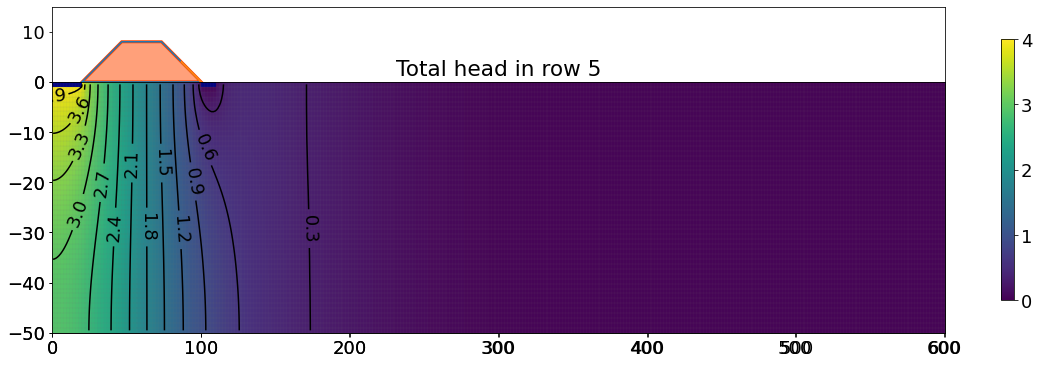

In [28]:
if __name__ == "__main__":
    count = 0
    for i in [0]:
        for j in [0]:
            try:
                model = ModFlow_dike(f"model_{count}")
                model.N_wall = i
                model.berm_width = j
                model.run_all()
                count+=1
            except:
                print (f"Sheetpile = {i} m, berm = {j} m")
